# Evaluate Metlin-CCS train and test in CCSBase

In [1]:
from mol2ccs.utils import performance_evaluation
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

from utils import (
    compare_models_by_adduct,
    compare_models_dimer_and_mol_type,
)


from rdkit import Chem
from rdkit.Chem import AllChem
from functools import lru_cache

In [2]:
pd.options.mode.copy_on_write = True

Change here the predictions for the 2/3 models to compare against

In [3]:
mol2ccs_preds = pd.read_parquet(
    "ccs-prediction-outputs/ccsbase_3d_pred.parquet"
)

graphccs_pred = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/graphccs/v2-graphccs-train-metlin-test-on-ccsbase-predictions.parquet"
)

sigmaccs_pred = pd.read_parquet(
    "ccs-prediction-outputs/final-experiments-paper/sigmaccs-old/results/ccsbase_3d_pred.parquet"
)

Ensure that the predictions are in the same order as the test set

In [8]:
assert (
    mol2ccs_preds.shape[0] == graphccs_pred.shape[0] == sigmaccs_pred.shape[0]
), "Lengths of predictions do not match"

assert (
    mol2ccs_preds["smiles"].tolist()
    == graphccs_pred["SMILES"].tolist()
    == sigmaccs_pred["smiles"].tolist()
), "Lengths of predictions do not match"

AssertionError: Lengths of predictions do not match

In [4]:
mol2ccs_preds.shape[0], graphccs_pred.shape[0], sigmaccs_pred.shape[0]

(10771, 10780, 10771)

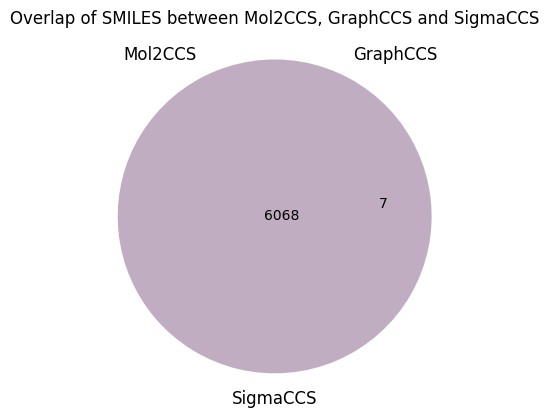

In [5]:
# Venn diagram of the three smiles
venn3(
    [
        set(mol2ccs_preds["smiles"].tolist()),
        set(graphccs_pred["SMILES"].tolist()),
        set(sigmaccs_pred["smiles"].tolist()),
    ],
    set_labels=["Mol2CCS", "GraphCCS", "SigmaCCS"],
)
plt.title("Overlap of SMILES between Mol2CCS, GraphCCS and SigmaCCS")

plt.show()

In [6]:
# Add "dimer", "mol_type", "ccs_type" to mol2ccs_preds from graphccs_pred

mol2ccs_preds["dimer"] = graphccs_pred["dimer"]
mol2ccs_preds["mol_type"] = graphccs_pred["mol_type"]
mol2ccs_preds["ccs_type"] = graphccs_pred["ccs_type"]

sigmaccs_pred["dimer"] = graphccs_pred["dimer"]
sigmaccs_pred["mol_type"] = graphccs_pred["mol_type"]
sigmaccs_pred["ccs_type"] = graphccs_pred["ccs_type"]

In [8]:
print(f"Performance metrics for Mol2CCS:\n#################################")

performance_mol2ccs, _ = performance_evaluation(
    input_pred=mol2ccs_preds["pred_ccs"],
    input_true=mol2ccs_preds["ccs"],
    output_type="dataframe",
)

print(f"\nPerformance metrics for GraphCCS:\n#################################")
performance_graphccs, _ = performance_evaluation(
    input_pred=graphccs_pred["Label"],
    input_true=graphccs_pred["predict"],
    output_type="dataframe",
)

print(f"\nPerformance metrics for SigmaCCS:\n#################################")
performance_sigmaccs, _ = performance_evaluation(
    input_pred=sigmaccs_pred["Predicted CCS"],
    input_true=sigmaccs_pred["ccs"],
    output_type="dataframe",
)

Performance metrics for Mol2CCS:
#################################
MAE : 25.38
MSE : 1026.91
RMSE : 32.05
R2 : 0.9
Mean Percent RSD : 13.15
Median Percent RSD : 10.8
Max Percent RSD : 235.56
Min Percent RSD : 0.0
Pearson's correlation : 0.95
Spearman's correlation : 0.91

Performance metrics for GraphCCS:
#################################
MAE : 10.4
MSE : 290.28
RMSE : 17.04
R2 : 0.94
Mean Percent RSD : 4.62
Median Percent RSD : 3.44
Max Percent RSD : 95.92
Min Percent RSD : 0.0
Pearson's correlation : 0.97
Spearman's correlation : 0.98

Performance metrics for SigmaCCS:
#################################
MAE : 21.31
MSE : 1108.36
RMSE : 33.29
R2 : 0.94
Mean Percent RSD : 9.34
Median Percent RSD : 5.83
Max Percent RSD : 221.76
Min Percent RSD : 0.0
Pearson's correlation : 0.97
Spearman's correlation : 0.97


In [9]:
# Concatenate the three performance dataframes and add a column for the method
performance = pd.concat(
    [performance_mol2ccs, performance_graphccs, performance_sigmaccs]
)
performance["method"] = (
    ["mol2ccs"] * performance_mol2ccs.shape[0]
    + ["graphccs"] * performance_graphccs.shape[0]
    + ["sigmaccs"] * performance_sigmaccs.shape[0]
)

In [10]:
performance

,Metric,Value,method
0,MAE,25.382187,mol2ccs
1,MSE,1026.908976,mol2ccs
2,RMSE,32.045421,mol2ccs
3,R2,0.898705,mol2ccs
4,Mean Percent RSD,13.154439,mol2ccs
5,Median Percent RSD,10.803110,mol2ccs
6,Max Percent RSD,235.560335,mol2ccs
7,Min Percent RSD,0.000493,mol2ccs
8,Pearson's correlation,0.948000,mol2ccs
9,Spearman's correlation,0.912126,mol2ccs


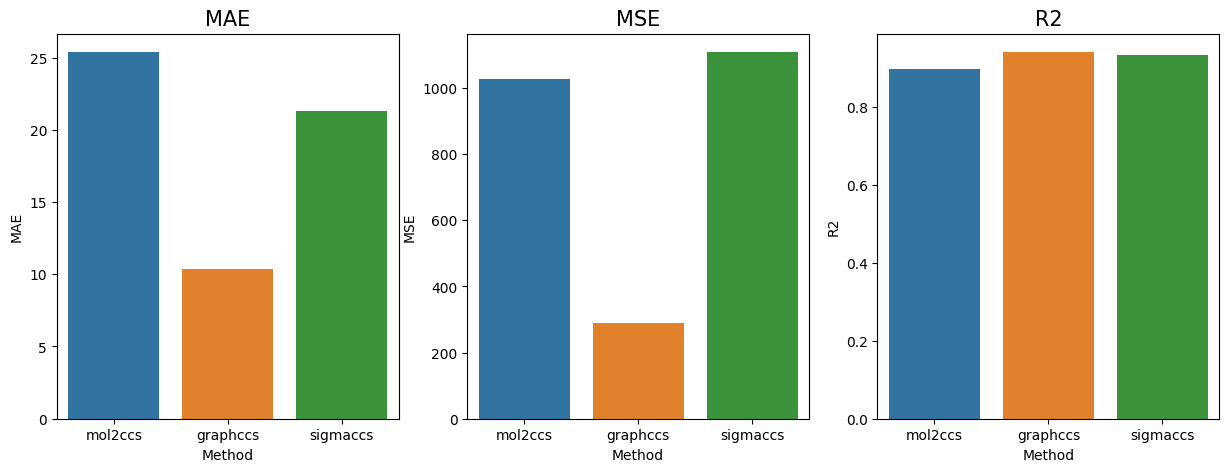

In [11]:
# Plot the performance metrics for the three methods in the same subplot using seaborn pairplor for MAE, RMSE, R2
fig = plt.figure(figsize=(15, 5))

gs = gridspec.GridSpec(1, 3)

for i, metric in enumerate(["MAE", "MSE", "R2"]):
    ax = plt.subplot(gs[0, i])

    # subset by metric
    subset = performance[performance["Metric"] == metric]

    sns.barplot(data=subset, x="method", y="Value", ax=ax, hue="method")

    ax.set_title(metric, fontsize=15)
    ax.set_xlabel("Method")
    ax.set_ylabel(metric)

# Compare models by Adduct

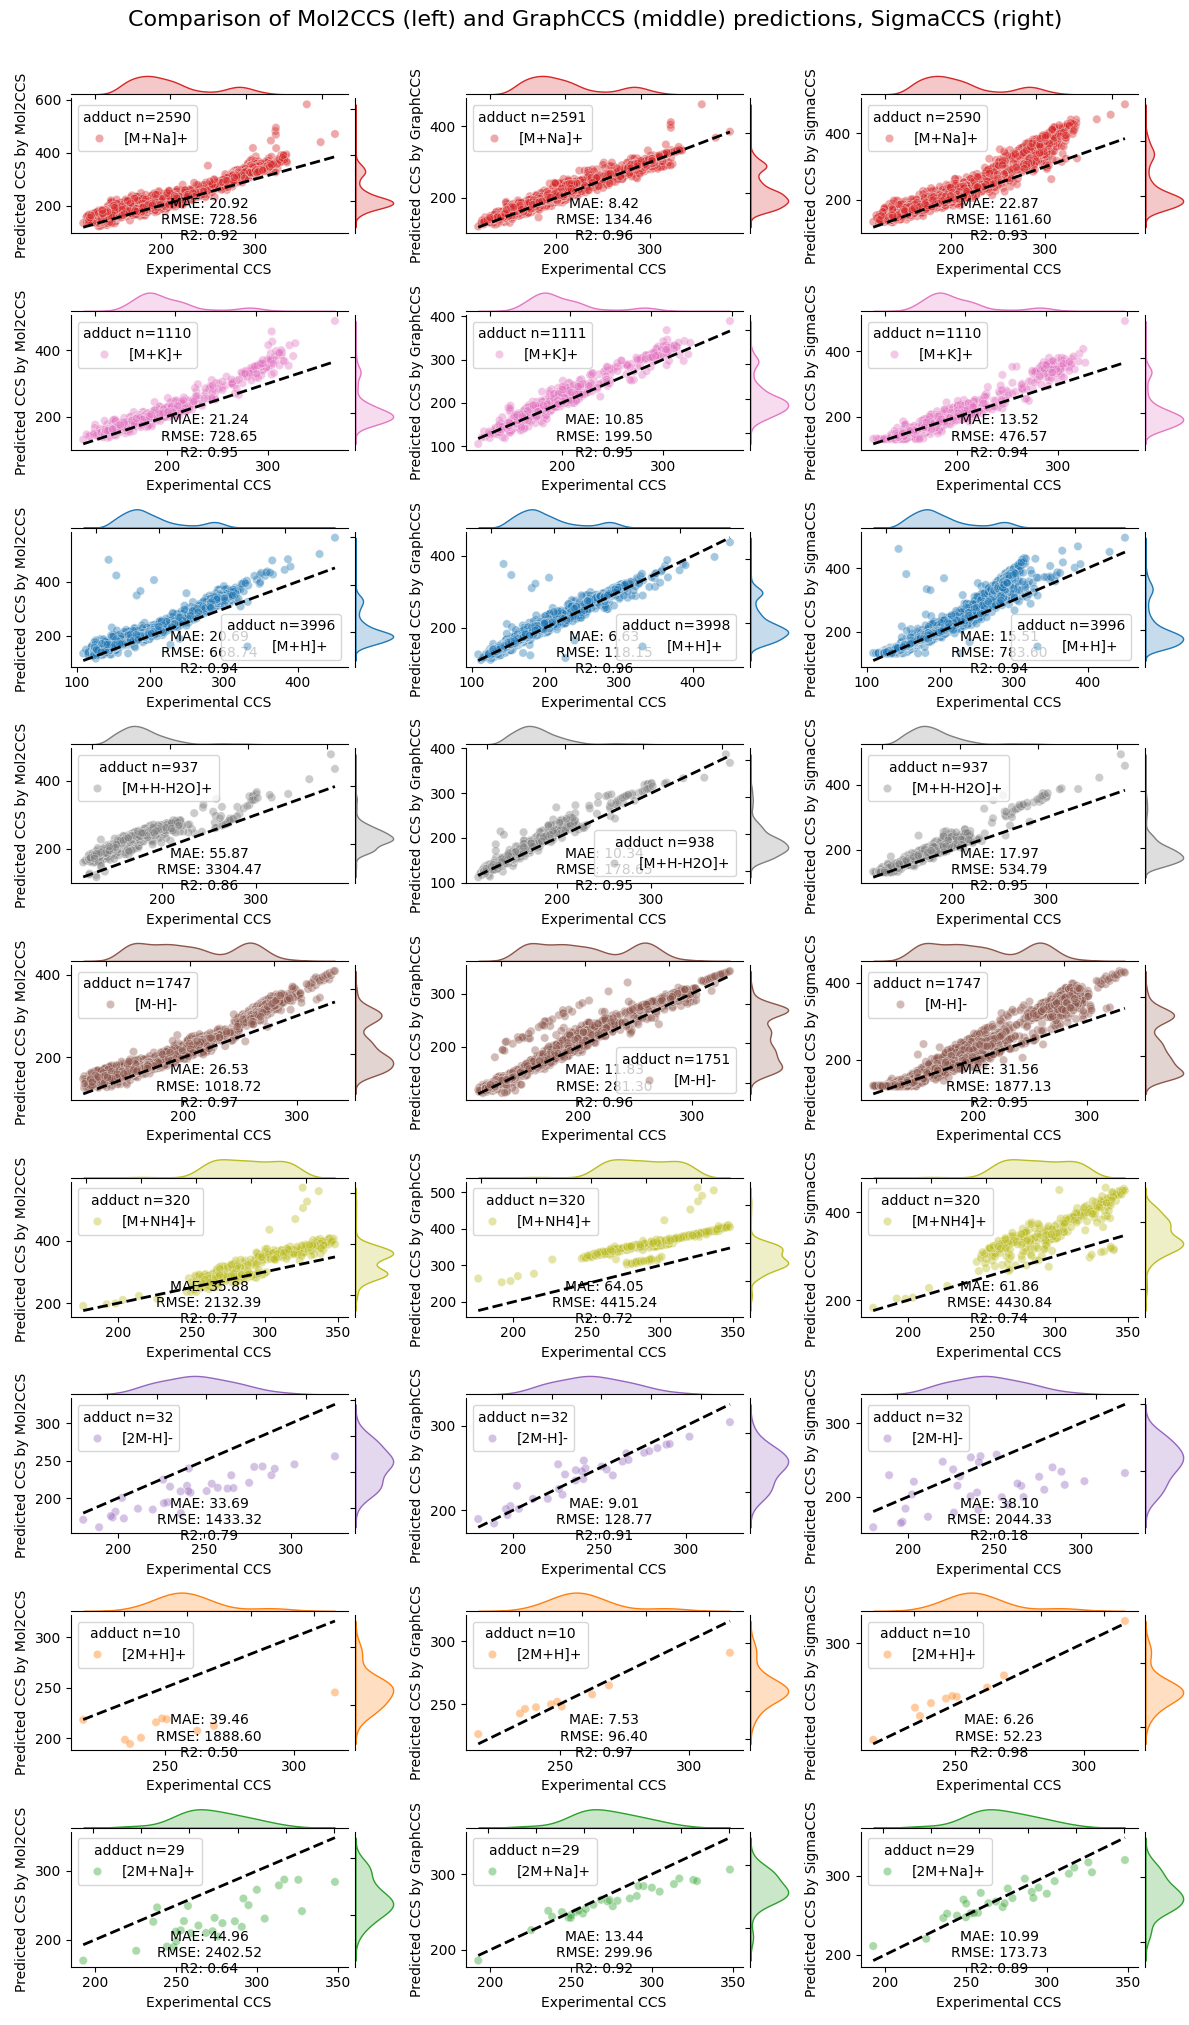

In [12]:
compare_models_by_adduct(
    model1=mol2ccs_preds,
    model2=graphccs_pred,
    model1_name="Mol2CCS",
    model1_ccs_label="ccs",
    model1_pred_ccs_label="pred_ccs",
    model1_adduct_label="adduct",
    model2_name="GraphCCS",
    model2_ccs_label="Label",
    model2_pred_ccs_label="predict",
    model2_adduct_label="Adduct",
    model3=sigmaccs_pred,
    model3_name="SigmaCCS",
    model3_ccs_label="ccs",
    model3_pred_ccs_label="Predicted CCS",
    model3_adduct_label="adduct",
)

# Compare models by Dimer/Monomer and Mol Type

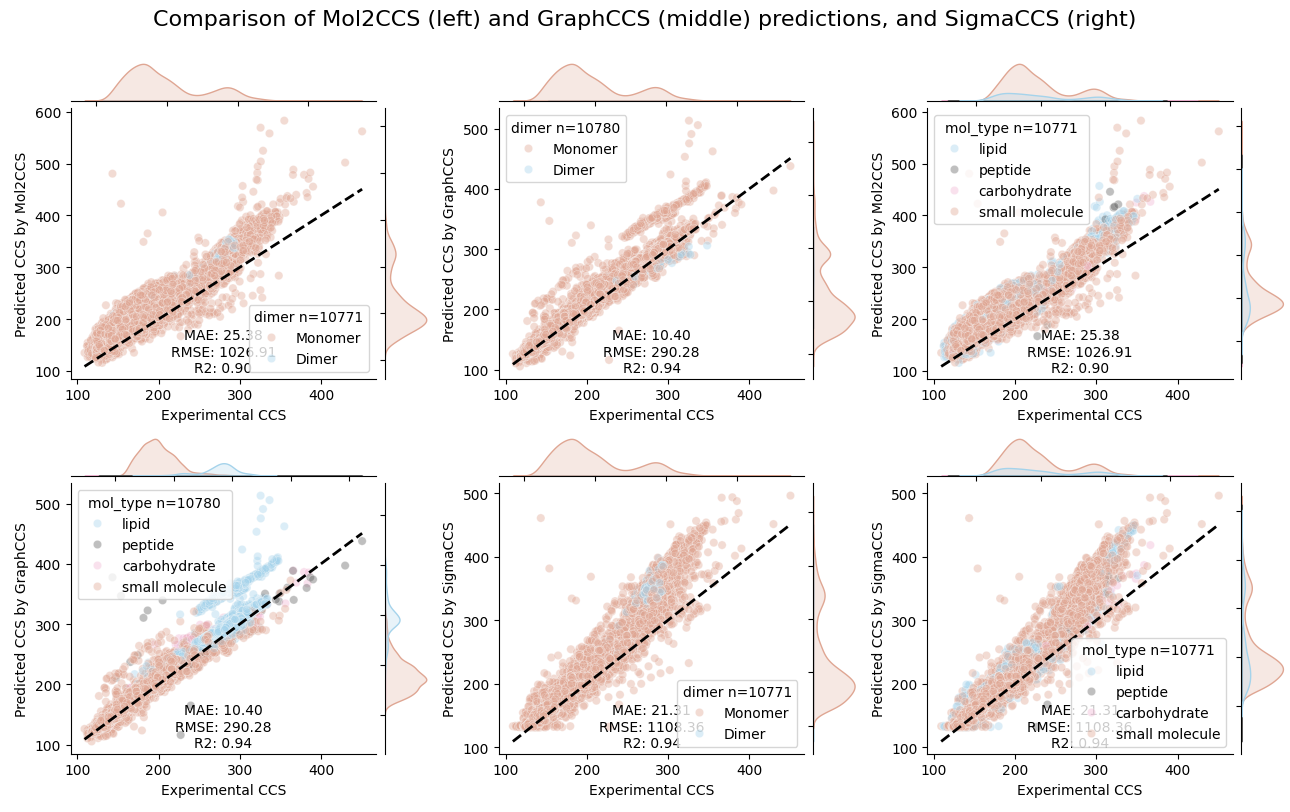

In [17]:
compare_models_dimer_and_mol_type(
    mol2ccs_preds,
    graphccs_pred,
    "Mol2CCS",
    "GraphCCS",
    model1_ccs_label="ccs",
    model1_pred_ccs_label="pred_ccs",
    model2_ccs_label="Label",
    model2_pred_ccs_label="predict",
    model3=sigmaccs_pred,
    model3_name="SigmaCCS",
    model3_ccs_label="ccs",
    model3_pred_ccs_label="Predicted CCS",
)

In [17]:
# Add a column to both dataframes indicating the difference between the predicted and experimental CCS
mol2ccs_preds["ccs_diff"] = mol2ccs_preds["pred_ccs"] - mol2ccs_preds["ccs"]
graphccs_pred["ccs_diff"] = graphccs_pred["predict"] - graphccs_pred["Label"]
sigmaccs_pred["ccs_diff"] = sigmaccs_pred["Predicted CCS"] - sigmaccs_pred["ccs"]


# sort the dataframe by the difference in CCS
mol2ccs_preds.sort_values("ccs_diff", inplace=True)
graphccs_pred.sort_values("ccs_diff", inplace=True)
sigmaccs_pred.sort_values("ccs_diff", inplace=True)

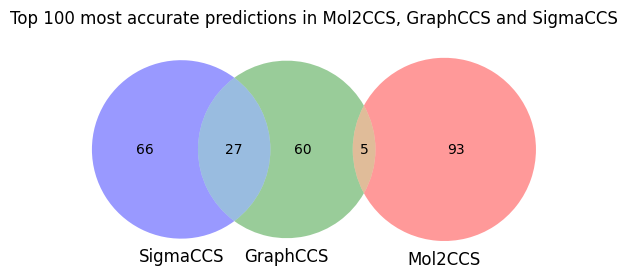

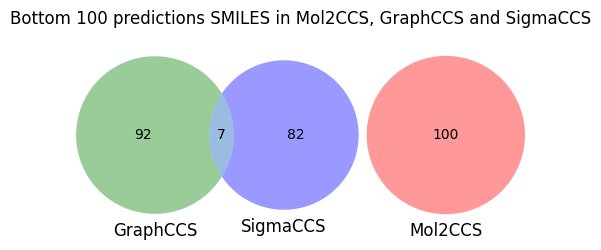

In [18]:
# make a venn diagram of the smiles in the two dataframes on top 100
venn3(
    subsets=(
        set(mol2ccs_preds["smiles"].tolist()[:100]),
        set(graphccs_pred["SMILES"].tolist()[:100]),
        set(sigmaccs_pred["smiles"].tolist()[:100]),
    ),
    set_labels=("Mol2CCS", "GraphCCS", "SigmaCCS"),
)
plt.title("Top 100 most accurate predictions in Mol2CCS, GraphCCS and SigmaCCS")

plt.show()
# same for the bottom 100

# title
venn3(
    subsets=(
        set(mol2ccs_preds["smiles"].tolist()[-100:]),
        set(graphccs_pred["SMILES"].tolist()[-100:]),
        set(sigmaccs_pred["smiles"].tolist()[-100:]),
    ),
    set_labels=("Mol2CCS", "GraphCCS", "SigmaCCS"),
)
plt.title("Bottom 100 predictions SMILES in Mol2CCS, GraphCCS and SigmaCCS")

plt.show()

Looking at the properties

In [19]:
@lru_cache(maxsize=5000)
def smiles_to_mol(smiles: str) -> Chem.Mol:
    """
    Convert a SMILES string to an RDKit molecule
    """
    return Chem.MolFromSmiles(smiles)


def mol_to_properties(mol):
    """Calculate a bunch of properties for a molecule like MW, logP, HBD, HBA, TPSA"""
    mw = AllChem.CalcExactMolWt(mol)
    logp = Chem.Crippen.MolLogP(mol)
    hbd = AllChem.CalcNumLipinskiHBD(mol)
    hba = AllChem.CalcNumLipinskiHBA(mol)
    tpsa = AllChem.CalcTPSA(mol)

    # calculate other properties

    return {"mw": mw, "logp": logp, "hbd": hbd, "hba": hba, "tpsa": tpsa}

In [20]:
# Calculate the smiles for each mol and add them to the dataframe as a column
mol2ccs_preds["mol"] = mol2ccs_preds["smiles"].apply(smiles_to_mol)
graphccs_pred["mol"] = graphccs_pred["SMILES"].apply(smiles_to_mol)
sigmaccs_pred["mol"] = sigmaccs_pred["smiles"].apply(smiles_to_mol)

In [21]:
# Calculate the properties for each molecule and add them to the dataframe as columns
mol2ccs_preds = pd.concat(
    [mol2ccs_preds, mol2ccs_preds["mol"].apply(mol_to_properties).apply(pd.Series)],
    axis=1,
)

graphccs_pred = pd.concat(
    [graphccs_pred, graphccs_pred["mol"].apply(mol_to_properties).apply(pd.Series)],
    axis=1,
)

sigmaccs_pred = pd.concat(
    [sigmaccs_pred, sigmaccs_pred["mol"].apply(mol_to_properties).apply(pd.Series)],
    axis=1,
)

In [22]:
# Correlate the properties with the difference in CCS (ccs_diff) and find if there is any property that correlates with the error

corr_mol2ccs = mol2ccs_preds[["ccs_diff", "mw", "logp", "hbd", "hba", "tpsa"]].corr()
corr_graphccs = graphccs_pred[["ccs_diff", "mw", "logp", "hbd", "hba", "tpsa"]].corr()
corr_sigmaccs = sigmaccs_pred[["ccs_diff", "mw", "logp", "hbd", "hba", "tpsa"]].corr()

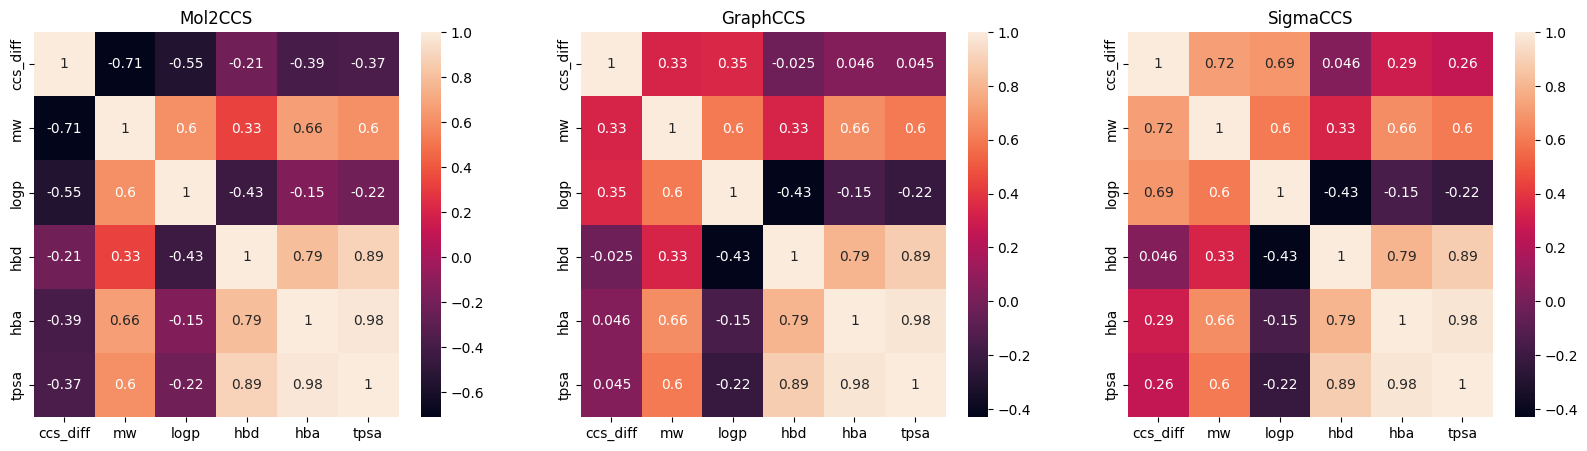

In [23]:
# two heatmaps side by side for the two models with the title
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(corr_mol2ccs, annot=True, ax=ax[0])
ax[0].set_title("Mol2CCS")

sns.heatmap(corr_graphccs, annot=True, ax=ax[1])

ax[1].set_title("GraphCCS")

sns.heatmap(corr_sigmaccs, annot=True, ax=ax[2])

ax[2].set_title("SigmaCCS")

plt.show()